In [1]:
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from Metrics import Accuracy, F1Score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
logs = pd.read_csv('logs')

In [3]:
test_data = pd.read_csv('test_cleared.csv')
y_test = torch.tensor(test_data.flag).to('cuda')
x_test = torch.tensor(np.load('test.npy')).to('cuda')

In [4]:
class TextClassificationNN(nn.Module):
    def __init__(self) -> None:
        super(TextClassificationNN, self).__init__()
        self.embedding = nn.Embedding(5000, 128)
        self.transformer_encoder_1 = nn.TransformerEncoder(nn.TransformerEncoderLayer(128, 8, 2048, batch_first=True), num_layers=3)
        self.output = nn.Linear(128, 4)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder_1(x)
        x = x.mean(dim=1)
        x = self.output(x)
        return x

In [5]:
test_dataset = TensorDataset(x_test, y_test)
batch_size = 64
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model = torch.load('model')
model.eval()
model.to('cuda')
metrics = [Accuracy(), F1Score(num_classes=4)]
metrics_values = {key.name:0 for key in metrics}
outputs = []
with torch.no_grad():
    for x,y in tqdm(test_data_loader, total=len(test_data_loader)):
        output = model(x)
        outputs.append(output)
        metrics_values['accuracy']+=metrics[0](output, y)
        metrics_values['f1score']+=metrics[1](output, y)
print('accuracy', metrics_values['accuracy']/len(test_data_loader))
print('f1score', metrics_values['f1score']/len(test_data_loader))

  0%|          | 0/232 [00:00<?, ?it/s]c:\Users\HAWK\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:685: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._transformer_encoder_layer_fwd(
100%|██████████| 232/232 [00:04<00:00, 54.12it/s]

accuracy 0.798895474137931
f1score 0.7884698951289548


In [29]:
np_list = [np.argmax(x.cpu().numpy(), axis=1) for x in outputs]

In [42]:
y_pred = np.concatenate(np_list)

In [44]:
y_true = y_test.cpu().numpy()

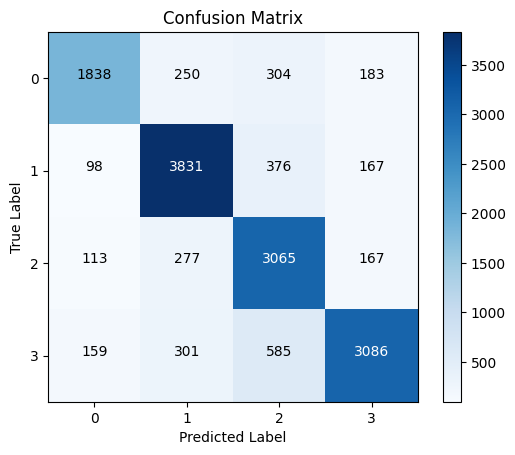

In [47]:
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_true)))
plt.xticks(tick_marks, np.unique(y_true))
plt.yticks(tick_marks, np.unique(y_true))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
thresh = cm.max() / 2.
for i, j in [(i, j) for i in range(cm.shape[0]) for j in range(cm.shape[1])]:
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.show()

In [49]:
11820/(11820+(98+113+159+301+277+585+167+167+376+250+304+183))

0.7986486486486486

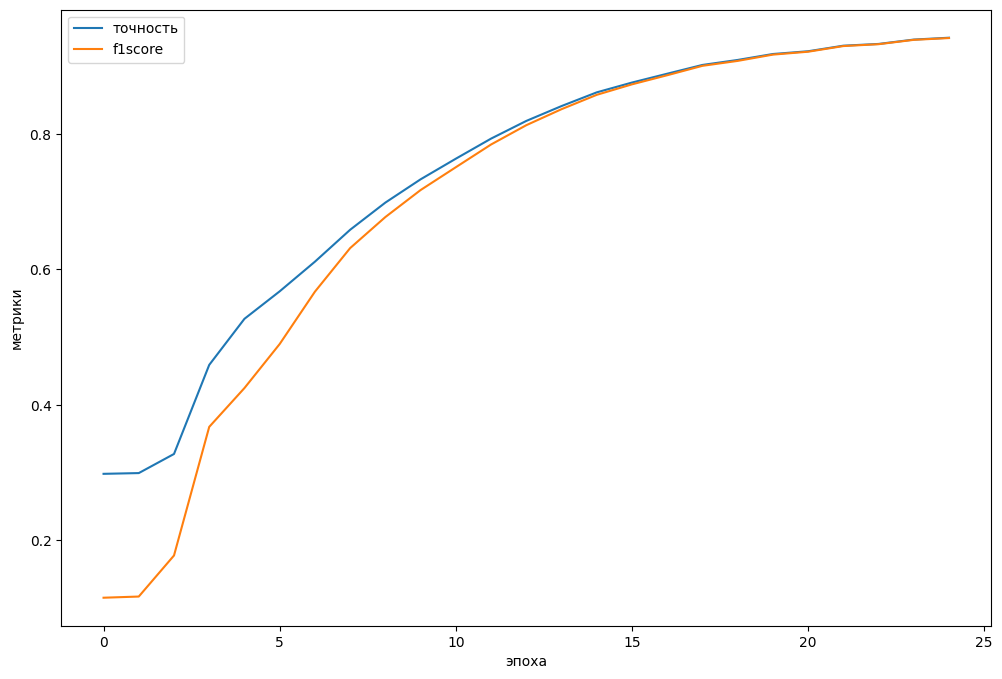

In [51]:
plt.figure(figsize=(12,8))
plt.plot(logs['accuracy'], label='точность')
plt.plot(logs['f1score'], label='f1score')
plt.legend()
plt.xlabel('эпоха')
plt.ylabel('метрики')
plt.show()

https://prnt.sc/cG_AxKhZXNw4
https://prnt.sc/9YLEqWgna0cs

Я решал задачу классификации текста, на наборе твиттерских данных(позапрошлая дз). Архитектура состоит из 3 трансформеров-энкодеров. Метрики и колбеки писал сам, т.к. в торче их нет(в python-ignite они есть). В принципе результатом я доволен. Точность и f1score довольно высокие. В принципе можно было бы добавить больше эпох, что я и сделал(раньше я обучал на 10, потом повысил до 25), т.к. переобучения не было(скрин приложил) и модель по-тихоньку обучалась. Если я правильно интерпретировал матрицу несоответствий, то точность 80%. 